## Purpose and Objective

The purpose of this data mining project is to study an issue that affects healthcare economics. The objective is to understand the dataset through EDA and use various machine learning models to predic payment trends.

In [1]:
#import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import folium
from folium.plugins import MarkerCluster

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
import seaborn as sns
from scipy.stats import zscore
from scipy.stats import ttest_ind
from scipy import stats
import statsmodels.api as sm

# for Mac errors
import warnings
warnings.filterwarnings("ignore")

## Data Preprocessing

Clean and prepare data for data analysis


    1. Import Dataset
    2. Clean Data
    3. Convert Attributes
    4. Handle Null Values
    5. Handle Target Column
    6. Identify and Examine Outliers
    7. Geographical Analysis
    8. Modeling Average Payment per User

#### **1. Import Dataset**

In [2]:
# load data
full_cbsa = pd.read_csv("cbsa2.csv")
full_cbsa.head(2)

,reference_period,type_of_service,aggregation_level,cbsa,cbsatitle,number_of_fee_for_service_beneficiaries,number_of_providers,average_number_of_users_per_provider,percentage_of_users_out_of_ffs_beneficiaries,number_of_users,...,average_number_of_providers_per_cbsa_dual_color,average_number_of_providers_per_cbsa_description,number_of_dual_eligible_users_dual_color,number_of_dual_eligible_users_description,percentage_of_dual_eligible_users_out_of_total_users_dual_color,percentage_of_dual_eligible_users_out_of_total_users_description,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_dual_color,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_dual_color_description,total_payment_dual_color,total_payment_description
0,2015-01-01 to 2015-12-31,Ambulance (Emergency & Non-Emergency),NATION + TERRITORIES,--ALL--,--ALL--,"37,359,009","9,078",424.34,10.31%,"3,852,199",...,,,,,,,,,,
1,2015-01-01 to 2015-12-31,Ambulance (Emergency & Non-Emergency),CBSA,10100,"Aberdeen, SD","7,526",3,231,9.21%,693,...,BLUE 1,Lowest 25% (Less than 5.00 Providers),BLUE 2,Second Lowest 25% (166 - 349 Dual Eligible Users),BLUE 2,Second Lowest 25% (21.67% - 26.95% of Total Us...,BLUE 3,Third Lowest 25% (17.06% - 19.32% of Total FFS...,BLUE 2,"Second Lowest 25% ($525,929.51 - $1,042,852.56 )"


In [3]:
full_cbsa.shape

(163035, 35)

Tab-delimited text with latitude and longitude data for cbsa territories. This data will be merged with the cbsa df to visualize market saturation metrics on map for geographical analysis. The choroleth map may help see patterns across geographic regions in the United States.

In [4]:
# load geometry
geo = pd.read_csv("geo.csv")
geo['NAME'] = geo['NAME'].str.replace(' Metro Area', '').str.replace(' Micro Area', '')
geo.head()

,NAME,INTPTLAT,INTPTLONG
0,"Abilene, TX",32.452022,-99.718743
1,"Adrian, MI",41.896022,-84.074356
2,"Aguadilla, PR",18.391555,-67.097202
3,"Akron, OH",41.146639,-81.350110
4,"Albany, OR",44.488898,-122.537208


Most of the raw data will be extracted, leaving out the most columns that were derived and from the columns with raw data. This way, a separate secondary analysis is conducted without previous calculations.

In [5]:
cbsa = full_cbsa.iloc[:, :15]
cbsa.head()

,reference_period,type_of_service,aggregation_level,cbsa,cbsatitle,number_of_fee_for_service_beneficiaries,number_of_providers,average_number_of_users_per_provider,percentage_of_users_out_of_ffs_beneficiaries,number_of_users,average_number_of_providers_per_cbsa,number_of_dual_eligible_users,percentage_of_dual_eligible_users_out_of_total_users,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries,total_payment
0,2015-01-01 to 2015-12-31,Ambulance (Emergency & Non-Emergency),NATION + TERRITORIES,--ALL--,--ALL--,"37,359,009","9,078",424.34,10.31%,"3,852,199",116.56,"1,085,184",28.17%,17.24%,"$3,430,203,620.67"
1,2015-01-01 to 2015-12-31,Ambulance (Emergency & Non-Emergency),CBSA,10100,"Aberdeen, SD","7,526",3,231,9.21%,693,3,174,25.11%,18.73%,"$588,150.97"
2,2015-01-01 to 2015-12-31,Ambulance (Emergency & Non-Emergency),CBSA,10140,"Aberdeen, WA","17,349",18,110.44,11.46%,"1,988",18,675,33.95%,19.55%,"$1,786,700.58"
3,2015-01-01 to 2015-12-31,Ambulance (Emergency & Non-Emergency),CBSA,10180,"Abilene, TX","25,198",11,271.09,11.83%,"2,982",11,907,30.42%,19.76%,"$2,003,346.18"
4,2015-01-01 to 2015-12-31,Ambulance (Emergency & Non-Emergency),CBSA,10220,"Ada, OK","7,570",5,104.8,6.92%,524,5,183,34.92%,12.12%,"$359,960.14"


There are true zeros for variables in quantitative (ratio) data; therefore, calculations such as geometric mean, harmonic mean, and percent variation are valid. The reference period is a quantitative (interval) variable that will be divided from start to end for easy interpretation of continuous variables. Qualitative (nominal) variables will serve as categorical exploratory variables, allowing for operations such as mode, entropy, contingency, and correlation. As for qualitative (ordinal) variables, the 'aggregation_level' has only one unique value; thus, it will not be investigated further, as no new information can be generated from it.

<table style="border:1px solid black;">
  <tr>
    <th width="200px" style="background-color: lightgrey; border:1px solid black;">Quantitative (interval)</th>
    <th width="200px" style="background-color: lightgrey; border:1px solid black;">Quantitative (ratio)   </th>
  </tr>
  <tr>
    <td style="background-color: lightblue; vertical-align: top; border:1px solid black;">reference_period</td>
    <td style="background-color: lightblue; vertical-align: top; border:1px solid black;">number_of_fee_for_service_beneficiaries,
number_of_providers,
average_number_of_users_per_provider,
percentage_of_users_out_of_ffs_beneficiaries,
number_of_users,
average_number_of_providers_per_cbsa,
number_of_dual_eligible_users,
percentage_of_dual_eligible_users_out_of_total_users,
percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries,
total_payment
</td>
  </tr>
</table>

<table>
  <tr>
    <th width="200px" style="background-color: lightgrey; border:1px solid black;">Qualitative (nominal)</th>
    <th width="200px" style="background-color: lightgrey; border:1px solid black;">Qualitative (ordinal)</th>
  </tr>
  <tr>
    <td style="background-color: lightblue; vertical-align: top; border:1px solid black;">type_of_service,
cbsa,
cbsatitle
    <td style="background-color: lightblue; vertical-align: top; border:1px solid black;">
aggregation_level
    </td>
  </tr>
</table>

#### **2. Clean Data**

Split or drop specified characters, rows, and columns for efficient referencing.

In [6]:
# remove percent and dollar signs
cbsa = cbsa.replace('%', '', regex=True)
cbsa = cbsa.replace('\$', '', regex=True)

In [7]:
# remove aggregate to remove previous calculations
cbsa = cbsa[cbsa['cbsa'] != '--ALL--']

In [8]:
# split city and state columns
cbsa[['city', 'state']] = cbsa['cbsatitle'].str.split(', ', expand=True)
cbsa.insert(0, 'state', cbsa.pop('state'))
cbsa.insert(0, 'city', cbsa.pop('city'))

In [9]:
# split reference period to start and end dates
cbsa[['start_date', 'end_date']] = cbsa['reference_period'].str.split(' to ', expand=True)
cbsa.insert(0, 'end_date', cbsa.pop('end_date'))
cbsa.insert(0, 'start_date', cbsa.pop('start_date'))
cbsa.drop(["reference_period"], axis = 1, inplace= True)

#### **3. Convert Attributes**

Convert variables to proper datatypes.

In [10]:
# convert date columns to datetime
cbsa[['start_date', 'end_date']] = cbsa[['start_date', 'end_date']].apply(pd.to_datetime)

In [11]:
# extract only the year
cbsa['year'] = cbsa['start_date'].dt.year

In [12]:
# view shape after columns created and previous calculation dropped
cbsa.shape

(162848, 19)

In [13]:
# convert numerical variables to integer or float
convert_numerical = [
    'number_of_fee_for_service_beneficiaries',
    'number_of_providers',
    'number_of_users',
    'number_of_dual_eligible_users',
    'average_number_of_users_per_provider',
    'percentage_of_users_out_of_ffs_beneficiaries',
    'average_number_of_providers_per_cbsa',
    'percentage_of_dual_eligible_users_out_of_total_users',
    'percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries',
    'total_payment'
]

for column in convert_numerical:
    cbsa[column] = cbsa[column].str.replace(' ', '').str.replace(',', '')
    cbsa[column] = pd.to_numeric(cbsa[column], downcast=None)

In [14]:
# identify and convert to categorical
convert_to_category = [
    'type_of_service',
    'cbsa',
    'cbsatitle',
    'city',
    'state',
    'aggregation_level',
]
cbsa[convert_to_category] = cbsa[convert_to_category].astype('category')

In [15]:
# confirm datatypes
print(cbsa.dtypes)

start_date                                                                  datetime64[ns]
end_date                                                                    datetime64[ns]
city                                                                              category
state                                                                             category
type_of_service                                                                   category
aggregation_level                                                                 category
cbsa                                                                              category
cbsatitle                                                                         category
number_of_fee_for_service_beneficiaries                                              int64
number_of_providers                                                                  int64
average_number_of_users_per_provider                                               float64

In [16]:
## Dictionary
cbsa_dict={1:"Start of The selected one-year time period of observations",
2:"End of the selected one-year time period of observations",
3:"City of the CBSA",
4:"State or Territory of the CBSA",
5:"The selected health service area",
6:"A variable classifying the observation as the State, County, CBSA or Nation + Territories level",
7:"Five digit code to specify CBSA to indicate Nation + Territories level",
8:"CBSA name to indicate Nation + Territories",
9:"Total number of FFS beneficiaries in selected geographic region for specified reference period and service area",
10:"Total number of providers in selected geographic region for specified reference period and service area",
11:"The average number of users per provider in selected geographic region for specified reference period and service area",
12:"The percentage of users out of FFS beneficiaries in selected geographic region for specified reference period and service area",
13:"The total number of users in selected geographic region for specified reference period and service area",
14:"The average number of providers per CBSA for specified reference period and service area. Only populated for CBSAs",
15:"The number of users qualifying for Medicare and any level of Medicaid coverage in selected geographic region for specified reference period and service area",
16:"The percentage of dual eligible users out of the total number of users in selected geographic region for specified reference period and service area",
17:"The percentage of dual eligible users out of the total number FFS beneficiaries in selected geographic region for specified reference period and service area",
18:"The total payment in selected geographic region for specified reference period and service area"}

#### **4. Handle Null Values**

In [17]:
# check null values
cbsa.isnull().sum()

start_date                                                                      0
end_date                                                                        0
city                                                                            0
state                                                                           0
type_of_service                                                                 0
aggregation_level                                                               0
cbsa                                                                            0
cbsatitle                                                                       0
number_of_fee_for_service_beneficiaries                                         0
number_of_providers                                                             0
average_number_of_users_per_provider                                         3812
percentage_of_users_out_of_ffs_beneficiaries                                    0
number_of_users 

**Investigate `average_number_of_users_per_provider`**

    - examine number of users and number of providers which were used to calculate average_number_of_users_per_provider 
    - use CMS information why provider count could be 0

In [18]:
cbsatitles_with_zero_providers = cbsa[cbsa['number_of_providers'] == 0]['cbsa']
cbsatitles_with_zero_providers

121       15100
182       17640
199       18380
208       18780
531       32260
          ...  
162967    46500
162970    46620
163006    48500
163014    48940
163028    49500
Name: cbsa, Length: 3812, dtype: category
Categories (961, object): ['10100', '10140', '10180', '10220', ..., '49700', '49740', '49780', '49820']

There are 3,812 areas that have 0 providers. Per CMS, "a provider is defined as serving a CBSA if, during the one-year reference period, the provider had paid claims for more than ten beneficiaries located in that CBSA." Verify if the number of users (FFS beneficiaries who have a paid claim for a service) per area were at least 10.

In [19]:
# check if cbsa have sufficient users to qualify
cbsa.loc[cbsa['number_of_users'] == cbsa['number_of_users'].min(),'number_of_users']

765       11
1949      11
2815      11
3288      11
3713      11
          ..
156802    11
156975    11
159581    11
162312    11
162479    11
Name: number_of_users, Length: 320, dtype: int64

**Observation:** The lowest number of user is 11, meaning the providers should be defined by CMS. Requirement is 10 and above. There appears to be many that are close to the cutoff. There may have been technicalities that did not qualify the providers according to CMS criteria. The latest information by the provider area will be calculated to replace the 3,812 providers with 0 values that do not make sense.

In [20]:
# impute number providers of 0 with previous data
cbsa['number_of_providers'].replace(0, np.nan, inplace=True)

In [21]:
# create a subset of cbsa with complete dual data
provider_subset = ['start_date','type_of_service','cbsa','number_of_providers']

cbsa_provider = cbsa[provider_subset].sort_values('start_date').dropna().drop_duplicates(
    subset=['type_of_service', 'cbsa'], keep='last')

In [22]:
# fill missing values with the most recent available data
match_cols1 = ['cbsa','type_of_service']
cbsa = cbsa.set_index(match_cols1).fillna(cbsa_provider.set_index(match_cols1)).reset_index()

In [23]:
remaining_zero_providers = cbsa[cbsa['number_of_providers'] == 0]['cbsa']
remaining_zero_providers

Series([], Name: cbsa, dtype: category
Categories (961, object): ['10100', '10140', '10180', '10220', ..., '49700', '49740', '49780', '49820'])

Due to lack of information, the remaining () will be replaced with 0s. More research is needed.

    1. How many are services with 0 providers were close to the 10 beneficiary cutoff?
    2. How many are services that are relatively new or from earlier years?
    3. How many are Telemedicine with special criteria?
    4. How many are providers that no longer operate?

In [24]:
# fill null with 0
cbsa['number_of_providers'] = cbsa['number_of_providers'].fillna(0)

**Investigate `number_of_dual_eligible_users`**

    - replace missing values with same data from the most recent previous reference period
    - estimate number of dual eligible using average qualifiers per type of sertice

In [25]:
# create a subset of cbsa with complete dual data
dual_subset = ['start_date','type_of_service','cbsa','number_of_dual_eligible_users']

cbsa_dual = cbsa[dual_subset].sort_values('start_date').dropna().drop_duplicates(
    subset=['type_of_service', 'cbsa'], keep='last')

In [26]:
# fill missing values with the most recent available data
match_cols2 = ['cbsa','type_of_service']
cbsa = cbsa.set_index(match_cols2).fillna(cbsa_dual.set_index(match_cols2)).reset_index()

The estimate of missing dual eligible users data is the average number of dual users per service type.

In [27]:
# aggregate mean of percentage_of_dual_eligible_users_out_of_total_users per service type

mean_percentage_service = cbsa.groupby('type_of_service')['percentage_of_dual_eligible_users_out_of_total_users'].mean()
mean_percentage_service = mean_percentage_service.reset_index()
mean_percentage_service

,type_of_service,percentage_of_dual_eligible_users_out_of_total_users
0,Ambulance (Emergency & Non-Emergency),27.484972
1,Ambulance (Emergency),27.981974
2,Ambulance (Non-Emergency),29.584675
3,Cardiac Rehabilitation Program,12.125258
4,Chiropractic Services,8.943611
5,Clinical Laboratory (Billing Independently),18.059210
6,Dialysis,39.513165
7,Federally Qualified Health Center (FQHC),45.332903
8,Home Health,21.352746
9,Hospice,20.758439


In [28]:
# fill missing values with average percentage
match_mean_dual_service = ['type_of_service']
cbsa = cbsa.set_index(match_mean_dual_service).fillna(mean_percentage_service.set_index(match_mean_dual_service)).reset_index()

In [29]:
# fill nulls of average_number_of_users_per_provider with num users/num providers
fill_avg_users_per_provider = cbsa['number_of_users']/cbsa['number_of_providers']
cbsa['average_number_of_users_per_provider'].fillna(fill_avg_users_per_provider, inplace=True)
cbsa['average_number_of_users_per_provider'].replace(np.inf, 0, inplace=True)

In [30]:
# fill nulls of number_of_dual_eligible_users by average number per service type
fill_dual_users = cbsa['number_of_users']*(cbsa[
    'percentage_of_dual_eligible_users_out_of_total_users']/100)
cbsa['number_of_dual_eligible_users'].fillna(fill_dual_users, inplace=True)

In [31]:
cbsa['percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries'] = cbsa[
    'number_of_dual_eligible_users']/cbsa['number_of_fee_for_service_beneficiaries']

In [32]:
# check null values
cbsa.isnull().sum()

type_of_service                                                             0
cbsa                                                                        0
start_date                                                                  0
end_date                                                                    0
city                                                                        0
state                                                                       0
aggregation_level                                                           0
cbsatitle                                                                   0
number_of_fee_for_service_beneficiaries                                     0
number_of_providers                                                         0
average_number_of_users_per_provider                                        0
percentage_of_users_out_of_ffs_beneficiaries                                0
number_of_users                                                 

In [33]:
users_per_service = cbsa.groupby('type_of_service')['number_of_users'].sum().reset_index()
users_per_service

,type_of_service,number_of_users
0,Ambulance (Emergency & Non-Emergency),31901593
1,Ambulance (Emergency),28738527
2,Ambulance (Non-Emergency),11196196
3,Cardiac Rehabilitation Program,1179525
4,Chiropractic Services,10711675
5,Clinical Laboratory (Billing Independently),124559121
6,Dialysis,2504261
7,Federally Qualified Health Center (FQHC),10936339
8,Home Health,22853273
9,Hospice,6755417


In [34]:
# label encoder object
label_encoder = LabelEncoder()

# create encoded column for heatmap in modeling section
cbsa['type_of_service_encoded'] = label_encoder.fit_transform(cbsa['type_of_service'])
cbsa

,type_of_service,cbsa,start_date,end_date,city,state,aggregation_level,cbsatitle,number_of_fee_for_service_beneficiaries,number_of_providers,average_number_of_users_per_provider,percentage_of_users_out_of_ffs_beneficiaries,number_of_users,average_number_of_providers_per_cbsa,number_of_dual_eligible_users,percentage_of_dual_eligible_users_out_of_total_users,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries,total_payment,year,type_of_service_encoded
0,Ambulance (Emergency & Non-Emergency),10100,2015-01-01,2015-12-31,Aberdeen,SD,CBSA,"Aberdeen, SD",7526,3.0,231.00,9.21,693,3.0,174.0,25.11,0.023120,588150.97,2015,0
1,Ambulance (Emergency & Non-Emergency),10140,2015-01-01,2015-12-31,Aberdeen,WA,CBSA,"Aberdeen, WA",17349,18.0,110.44,11.46,1988,18.0,675.0,33.95,0.038907,1786700.58,2015,0
2,Ambulance (Emergency & Non-Emergency),10180,2015-01-01,2015-12-31,Abilene,TX,CBSA,"Abilene, TX",25198,11.0,271.09,11.83,2982,11.0,907.0,30.42,0.035995,2003346.18,2015,0
3,Ambulance (Emergency & Non-Emergency),10220,2015-01-01,2015-12-31,Ada,OK,CBSA,"Ada, OK",7570,5.0,104.80,6.92,524,5.0,183.0,34.92,0.024174,359960.14,2015,0
4,Ambulance (Emergency & Non-Emergency),10300,2015-01-01,2015-12-31,Adrian,MI,CBSA,"Adrian, MI",16863,18.0,103.94,11.10,1871,18.0,529.0,28.27,0.031370,1524406.98,2015,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162843,Telemedicine,49660,2023-01-01,2023-12-31,Youngstown-Warren-Boardman,OH-PA,CBSA,"Youngstown-Warren-Boardman, OH-PA",60651,13.0,74.38,1.59,967,13.0,222.0,22.96,0.003660,192700.78,2023,20
162844,Telemedicine,49700,2023-01-01,2023-12-31,Yuba City,CA,CBSA,"Yuba City, CA",28180,39.0,45.92,6.36,1791,39.0,566.0,31.60,0.020085,325781.43,2023,20
162845,Telemedicine,49740,2023-01-01,2023-12-31,Yuma,AZ,CBSA,"Yuma, AZ",26729,10.0,52.80,1.98,528,10.0,78.0,14.77,0.002918,62069.58,2023,20
162846,Telemedicine,49780,2023-01-01,2023-12-31,Zanesville,OH,CBSA,"Zanesville, OH",11997,12.0,43.67,4.37,524,12.0,257.0,49.05,0.021422,102256.78,2023,20


In [35]:
le_services = cbsa['type_of_service_encoded'].unique()
le_services

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

21 service types encoded, matching the available service types.

In [36]:
unique_states = cbsa['state'].unique()
unique_states

['SD', 'WA', 'TX', 'OK', 'MI', ..., 'VA-NC', 'DC-VA-MD-WV', 'VA-WV', 'MA-CT', 'OH-PA']
Length: 102
Categories (102, object): ['AK', 'AL', 'AL-GA', 'AR', ..., 'WV-OH', 'WV-VA', 'WY', 'WY-ID']

**Observation:** some providers were 0 and therfefore error calculating `average_number_of_users_per_provider`.

Number of Fee-For-Service (FFS) Beneficiaries, Number of Providers, Number of Users, Number of Dual Eligible Users, Total Payment, reference_period, type_of_service, cbsa

All service types will be aggregated, box plot, compared by payment. Isolate and examine which has the most outliers.

#### **5. Handle `average_payment_per_user` to ensure  comparability across CBSA**

The target variable, `average_payment_per_user` is a standardized metric calculated by the average of `total_payment` over the `number_of_users`. This metric accounts for difference in number of users across cbsa which could be meaningful when assessing cost-effectiveness or fraud. The understanding of the average cost per unit of service can help in comparing efficiency across different cbsa. The limitation of using this target variable is the differences in service popularity which can fluctuate over time or beneficiary health status.

$$ \text{Average Payment per User} = \frac{\text{Total Payment * Cost of Health Index}}{\text{Number of Users}} $$

    - The total payment will be adjusted by state cost of health index
    - Then, the total will be divided by the number of users

**Apply Cost of Health Index to `total_payment`**

In [37]:
# cost of health index dictionary
cost_index = {
    'AK' : 1.48, 'AL' : 0.87, 'AL-GA' : 0.87, 'AR' : 0.88, 'AR-MO' : 0.88, 
    'AR-OK' : 0.88, 'AZ' : 0.94, 'CA' : 1.09, 'CO' : 1.00, 'CT' : 1.09, 
    'DC-VA-MD-WV' : 1.47, 'DE' : 1.03, 'FL' : 0.97, 'GA' : 1.00, 
    'GA-AL' : 1.00, 'GA-SC' : 0.91, 'HI' : 1.23, 'IA' : 0.99, 
    'IA-IL' : 0.99, 'IA-IL-MO' : 0.99, 'IA-NE-SD' : 0.99, 'ID' : 0.99, 
    'ID-WA' : 0.99, 'IL' : 0.95, 'IL-IN-WI' : 0.95, 'IL-MO' : 0.95, 
    'IN' : 0.96, 'IN-KY' : 0.96, 'IN-MI' : 0.96, 'KS' : 0.97, 'KY' : 0.84, 
    'KY-IL' : 0.84, 'KY-IN' : 0.84, 'LA' : 0.99, 'MA' : 1.13, 'MA-CT' : 1.13, 
    'MA-NH' : 1.13, 'MD' : 0.97, 'MD-DE' : 0.97, 'MD-WV' : 0.97, 'ME' : 1.03, 
    'MI' : 0.93, 'MI-WI' : 0.93, 'MN' : 1.09, 'MN-WI' : 1.09, 'MO' : 0.90, 
    'MO-IL' : 0.90, 'MO-KS' : 0.90, 'MS' : 0.98, 'MS-LA' : 0.98, 'MT' : 0.98, 
    'NC' : 1.08, 'NC-SC' : 1.08, 'ND' : 1.11, 'ND-MN' : 1.11, 'NE' : 0.98, 
    'NE-IA' : 0.98, 'NH' : 1.13, 'NH-VT' : 1.13, 'NJ' : 0.99, 'NM' : 0.99, 
    'NV' : 0.92, 'NY' : 1.06, 'NY-NJ-PA' : 1.06, 'OH' : 0.98, 'OH-KY-IN' : 0.98, 
    'OH-PA' : 0.98, 'OK' : 0.93, 'OR' : 1.05, 'OR-ID' : 1.05, 'OR-WA' : 1.05, 
    'PA' : 0.94, 'PA-NJ' : 0.96, 'PA-NJ-DE-MD' : 0.94, 'PR' : 0.69, 'RI-MA' : 1.08, 
    'SC' : 0.95, 'SC-NC' : 0.95, 'SD' : 0.98, 'TN' : 0.88, 'TN-GA' : 0.88, 
    'TN-KY' : 0.88, 'TN-MS-AR' : 0.88, 'TN-VA' : 0.88, 'TX' : 0.94, 'TX-AR' : 0.94, 
    'UT' : 0.91, 'UT-ID' : 0.91, 'VA' : 1.02, 'VA-NC' : 1.02, 'VA-WV' : 1.02, 
    'VT' : 1.06, 'WA' : 1.20, 'WI' : 1.12, 'WI-MI' : 1.12, 'WI-MN' : 1.12, 'WV' : 0.97, 
    'WV-KY-OH' : 0.97, 'WV-OH' : 0.97, 'WV-VA' : 0.97, 'WY' : 1.00, 'WY-ID' : 1.00
}

In [38]:
# use dictionary to map states to their cost of health index
cbsa['cost_of_health_index'] = cbsa['state'].map(cost_index)
cbsa['total_payment_adjusted'] = cbsa['total_payment']*cbsa['cost_of_health_index']

**Normalize `total_payment_adjusted` by health service utilization**

In [39]:
# create column for normalized total payment
cbsa['total_payment_adj_z'] = cbsa['total_payment_adjusted']/cbsa['number_of_users']

In [40]:
# statistics
cbsa.describe()

,start_date,end_date,number_of_fee_for_service_beneficiaries,number_of_providers,average_number_of_users_per_provider,percentage_of_users_out_of_ffs_beneficiaries,number_of_users,average_number_of_providers_per_cbsa,number_of_dual_eligible_users,percentage_of_dual_eligible_users_out_of_total_users,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries,total_payment,year,type_of_service_encoded,cost_of_health_index,total_payment_adjusted,total_payment_adj_z
count,162848,162848,1.628480e+05,162848.000000,162848.000000,162848.000000,1.628480e+05,162848.000000,162848.000000,162848.000000,162848.000000,1.628480e+05,162848.000000,162848.000000,162848.00000,1.628480e+05,162848.000000
mean,2019-01-12 09:51:07.144822016,2020-01-11 15:09:18.145018624,3.876744e+04,50.151767,113.162370,12.941694,5.105435e+03,50.072258,930.209669,23.232540,0.023898,1.158631e+07,2019.030931,9.925323,0.98537,1.171921e+07,8359.039088
min,2015-01-01 00:00:00,2015-12-31 00:00:00,4.070000e+02,0.000000,0.000000,0.010000,1.100000e+01,0.000000,0.983797,0.470000,0.000022,5.953100e+02,2015.000000,0.000000,0.69000,4.107639e+02,26.666471
25%,2017-01-01 00:00:00,2017-12-31 00:00:00,6.180000e+03,4.000000,41.000000,2.560000,2.380000e+02,4.000000,47.000000,12.730000,0.004694,2.189874e+05,2017.000000,5.000000,0.94000,2.141422e+05,249.431556
50%,2019-01-01 00:00:00,2019-12-31 00:00:00,1.196600e+04,10.000000,64.960000,5.890000,8.010000e+02,10.000000,159.000000,20.240000,0.012421,9.170519e+05,2019.000000,10.000000,0.98000,8.994380e+05,652.130172
75%,2021-01-01 00:00:00,2021-12-31 00:00:00,2.689500e+04,28.000000,128.000000,15.610000,2.830000e+03,28.000000,517.000000,30.780000,0.030779,4.449768e+06,2021.000000,15.000000,1.02000,4.411305e+06,5864.095093
max,2023-01-01 00:00:00,2023-12-31 00:00:00,2.523066e+06,16732.000000,2581.130000,75.080000,1.421406e+06,16732.000000,231507.000000,100.000000,0.496762,6.625352e+09,2023.000000,20.000000,1.48000,7.022873e+09,358333.097520
std,NaN,NaN,1.176749e+05,278.113821,136.809881,15.949473,2.603557e+04,278.108241,5092.474592,13.727376,0.031046,8.285980e+07,2.570610,6.044600,0.08800,8.663620e+07,18017.080283


In [41]:
# define handled target column
target_col = 'total_payment_adj_z'

#### **6. Identify and Examine Outliers**

Outliers Removed Based on Interquartile Range

In [42]:
cbsav1 = cbsa
cbsav1

,type_of_service,cbsa,start_date,end_date,city,state,aggregation_level,cbsatitle,number_of_fee_for_service_beneficiaries,number_of_providers,...,average_number_of_providers_per_cbsa,number_of_dual_eligible_users,percentage_of_dual_eligible_users_out_of_total_users,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries,total_payment,year,type_of_service_encoded,cost_of_health_index,total_payment_adjusted,total_payment_adj_z
0,Ambulance (Emergency & Non-Emergency),10100,2015-01-01,2015-12-31,Aberdeen,SD,CBSA,"Aberdeen, SD",7526,3.0,...,3.0,174.0,25.11,0.023120,588150.97,2015,0,0.98,5.763880e+05,831.728644
1,Ambulance (Emergency & Non-Emergency),10140,2015-01-01,2015-12-31,Aberdeen,WA,CBSA,"Aberdeen, WA",17349,18.0,...,18.0,675.0,33.95,0.038907,1786700.58,2015,0,1.20,2.144041e+06,1078.491296
2,Ambulance (Emergency & Non-Emergency),10180,2015-01-01,2015-12-31,Abilene,TX,CBSA,"Abilene, TX",25198,11.0,...,11.0,907.0,30.42,0.035995,2003346.18,2015,0,0.94,1.883145e+06,631.504161
3,Ambulance (Emergency & Non-Emergency),10220,2015-01-01,2015-12-31,Ada,OK,CBSA,"Ada, OK",7570,5.0,...,5.0,183.0,34.92,0.024174,359960.14,2015,0,0.93,3.347629e+05,638.860554
4,Ambulance (Emergency & Non-Emergency),10300,2015-01-01,2015-12-31,Adrian,MI,CBSA,"Adrian, MI",16863,18.0,...,18.0,529.0,28.27,0.031370,1524406.98,2015,0,0.93,1.417698e+06,757.722336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162843,Telemedicine,49660,2023-01-01,2023-12-31,Youngstown-Warren-Boardman,OH-PA,CBSA,"Youngstown-Warren-Boardman, OH-PA",60651,13.0,...,13.0,222.0,22.96,0.003660,192700.78,2023,20,0.98,1.888468e+05,195.291380
162844,Telemedicine,49700,2023-01-01,2023-12-31,Yuba City,CA,CBSA,"Yuba City, CA",28180,39.0,...,39.0,566.0,31.60,0.020085,325781.43,2023,20,1.09,3.551018e+05,198.270105
162845,Telemedicine,49740,2023-01-01,2023-12-31,Yuma,AZ,CBSA,"Yuma, AZ",26729,10.0,...,10.0,78.0,14.77,0.002918,62069.58,2023,20,0.94,5.834541e+04,110.502661
162846,Telemedicine,49780,2023-01-01,2023-12-31,Zanesville,OH,CBSA,"Zanesville, OH",11997,12.0,...,12.0,257.0,49.05,0.021422,102256.78,2023,20,0.98,1.002116e+05,191.243596


In [43]:
def remove_outliers(df, col_name):
    q1 = df[col_name].quantile(0.25)
    q3 = df[col_name].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df[(df[col_name] >= lower_bound) & (df[col_name] <= upper_bound)]

grouped = cbsa.groupby('type_of_service')
cbsa_outliers_removed = grouped.apply(remove_outliers, target_col)
cbsa_outliers_removed = cbsa_outliers_removed.reset_index(drop=True)

In [44]:
print(len(cbsa)-len(cbsa_outliers_removed), "outliers removed from CBSA")

5715 outliers removed from CBSA


In [45]:
# replace original cbsa with outliers removed
cbsa = cbsa_outliers_removed

## Data Visualization

    1. Payment Trends
    2. Box Plot of Average Payment per User
    3. Visualize ratio of users to providers across CBSA

#### **1. Payment Trends**

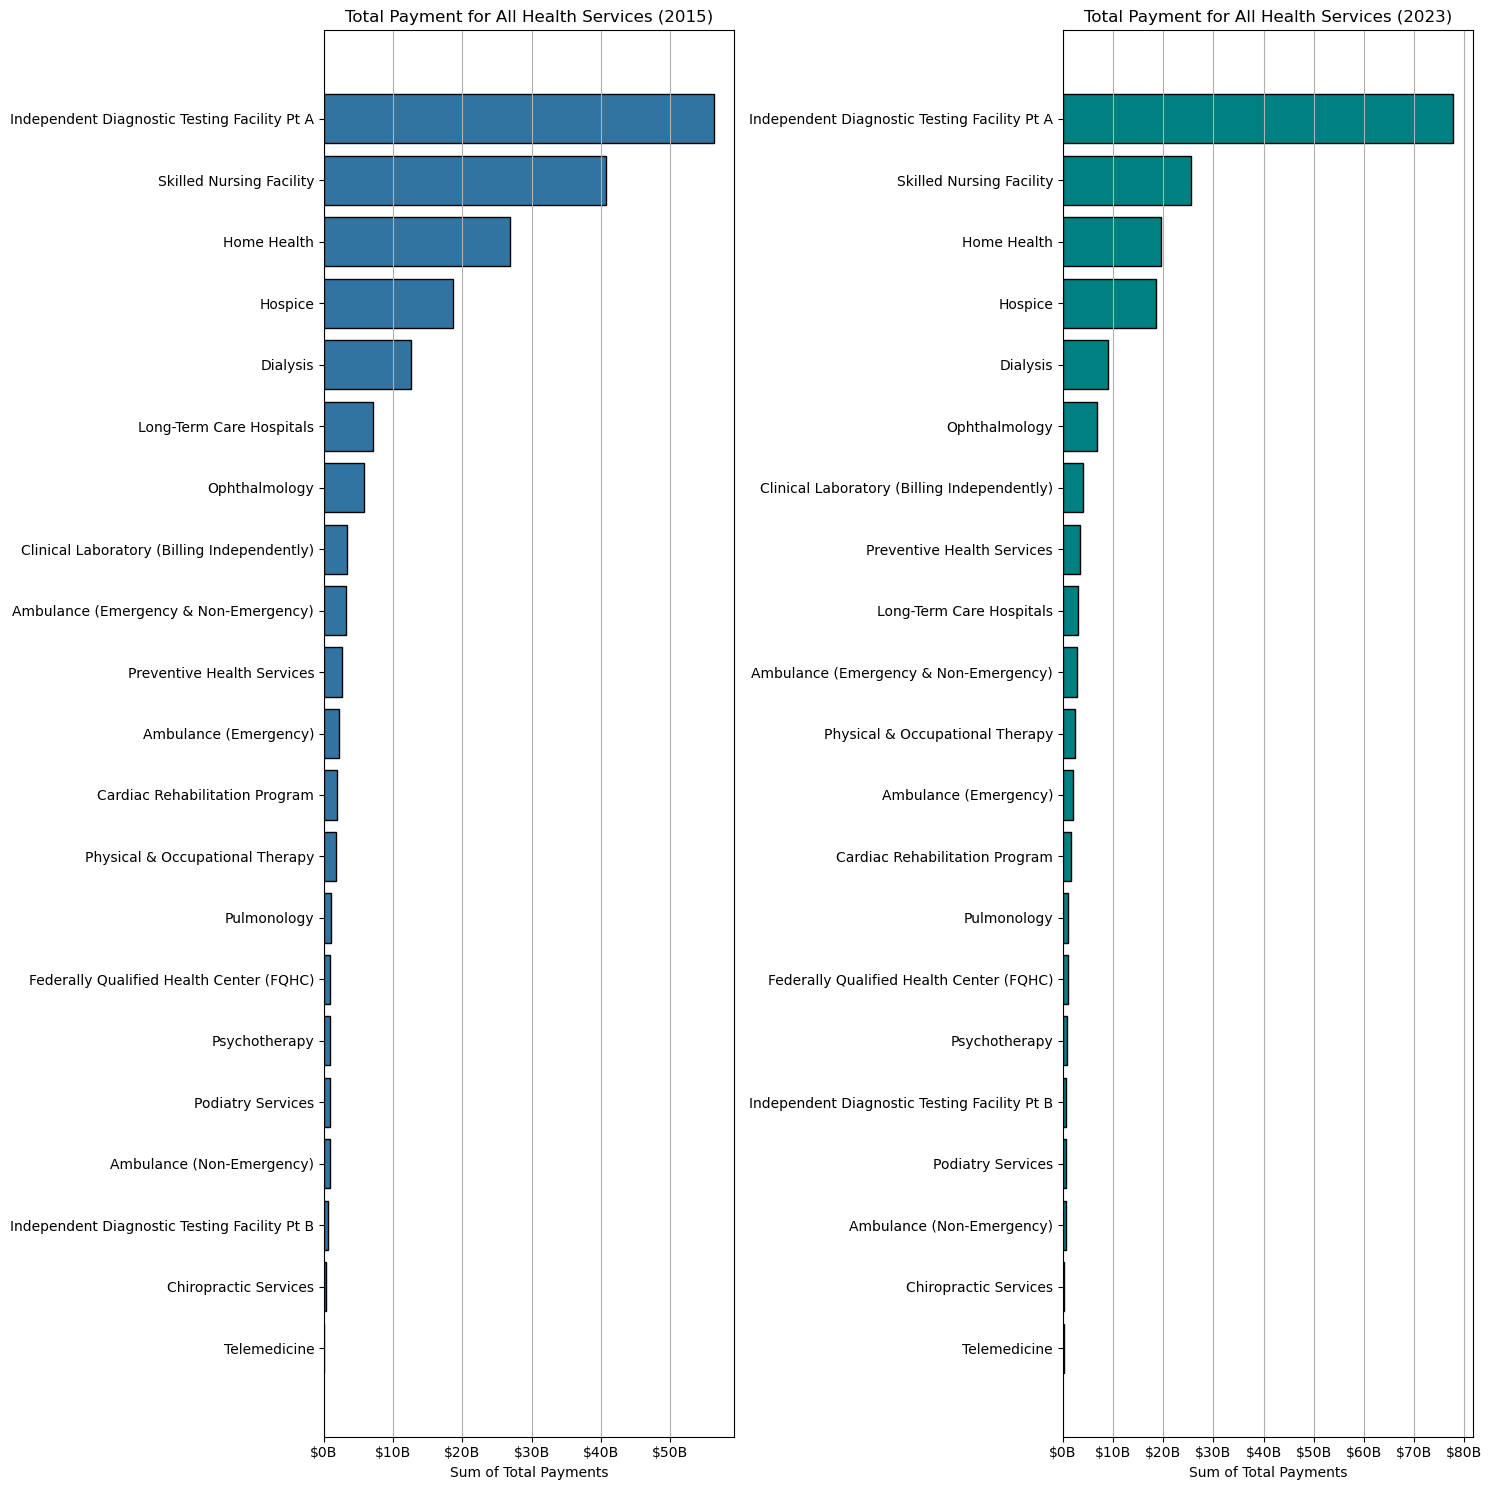

In [46]:
def filter_and_group_by_year(cbsa, year):
    cbsa_year = cbsa[cbsa['year'] == year]
    service_payment_year = cbsa_year.groupby('type_of_service', as_index=False)['total_payment'].sum()
    service_payment_year.sort_values(by='total_payment', inplace=True)
    return service_payment_year

def plot_service_payment(service_payment, title, color, ax):
    ax.yaxis.grid(False)
    ax.xaxis.grid(True)
    ax.barh(service_payment['type_of_service'], service_payment['total_payment'], color=color, edgecolor='black')
    ax.set_title(title)
    ax.set_xlabel("Sum of Total Payments")
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_dollars))

fig, axs = plt.subplots(1, 2, figsize=(15, 15))

# Format x-axis for readability
def format_dollars(x, pos):
    return '${:,.0f}B'.format(x / 1e9)
    
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_dollars))

service_payment_2015 = filter_and_group_by_year(cbsa, 2015)
plot_service_payment(service_payment_2015, "Total Payment for All Health Services (2015)", '#3274a1', axs[0])

service_payment_2023 = filter_and_group_by_year(cbsa, 2023)
plot_service_payment(service_payment_2023, "Total Payment for All Health Services (2023)", 'teal', axs[1])

plt.tight_layout()
plt.show()

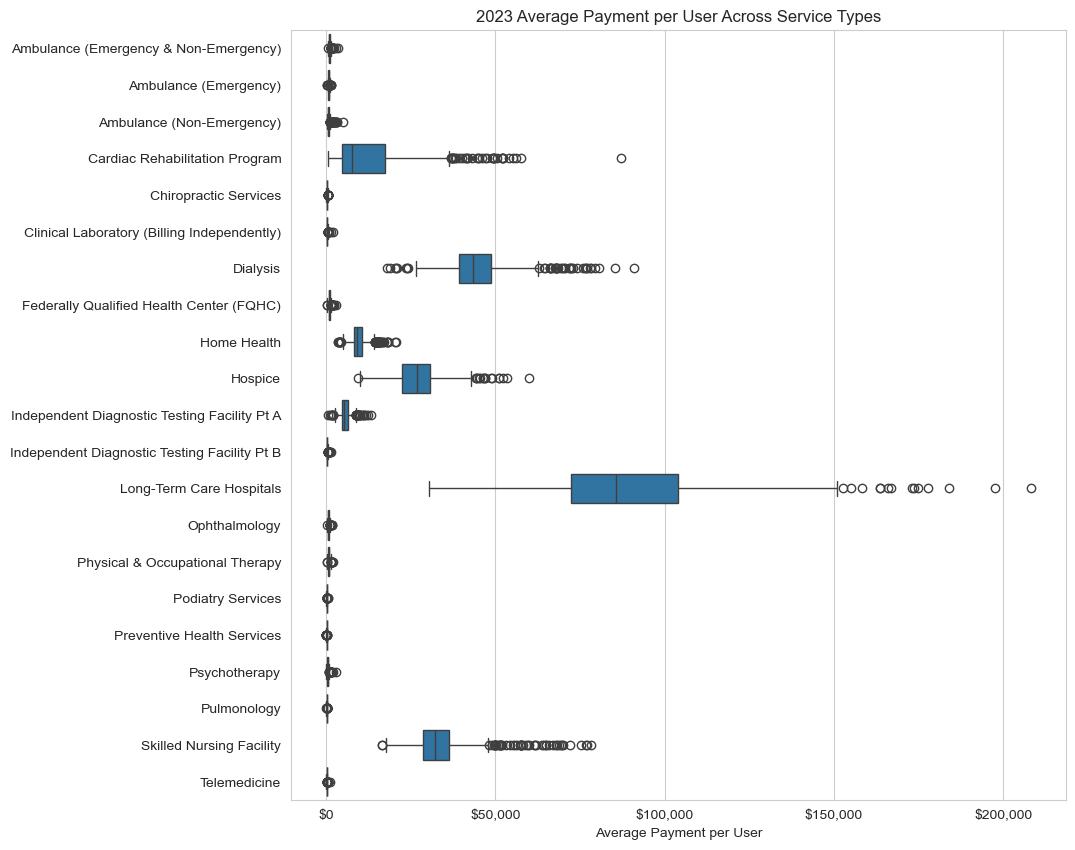

In [47]:
# grid for all visualizations
ax2 = sns.set_style("whitegrid")

# readability
plt.figure(figsize=(10,10))

# horizontal boxplot for 2023
ax2 = sns.boxplot(y='type_of_service', x='total_payment_adj_z', 
    data=cbsav1[cbsav1['year'] == 2023])

# labels
ax2.set_title('2023 Average Payment per User Across Service Types')
ax2.set_xlabel('Average Payment per User')
ax2.set_ylabel('')

# format x-axis for readability
def format_dollars(x, pos):
    return '${:,.0f}'.format(x)
    
# apply format
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_dollars))

plt.show()

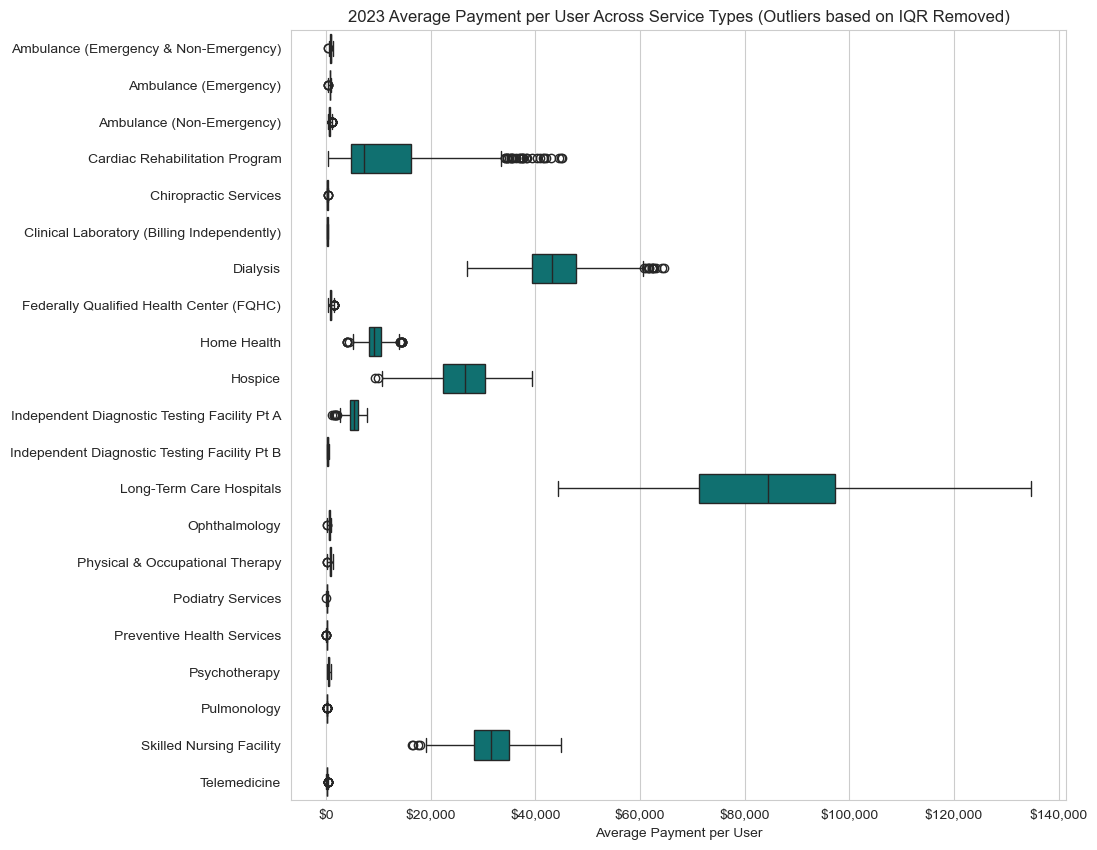

In [48]:
# readability
plt.figure(figsize=(10,10))
ax3 = sns.set_style("whitegrid")

# horizontal boxplot for 2023
ax3 = sns.boxplot(y='type_of_service', x='total_payment_adj_z', 
    data=cbsa[cbsa['year'] == 2023],
    color='teal')

# labels
ax3.set_title('2023 Average Payment per User Across Service Types (Outliers based on IQR Removed)')
ax3.set_xlabel('Average Payment per User')
ax3.set_ylabel('')

# format x-axis for readability
def format_dollars(x, pos):
    return '${:,.0f}'.format(x)
    
# apply format
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_dollars))

plt.show()

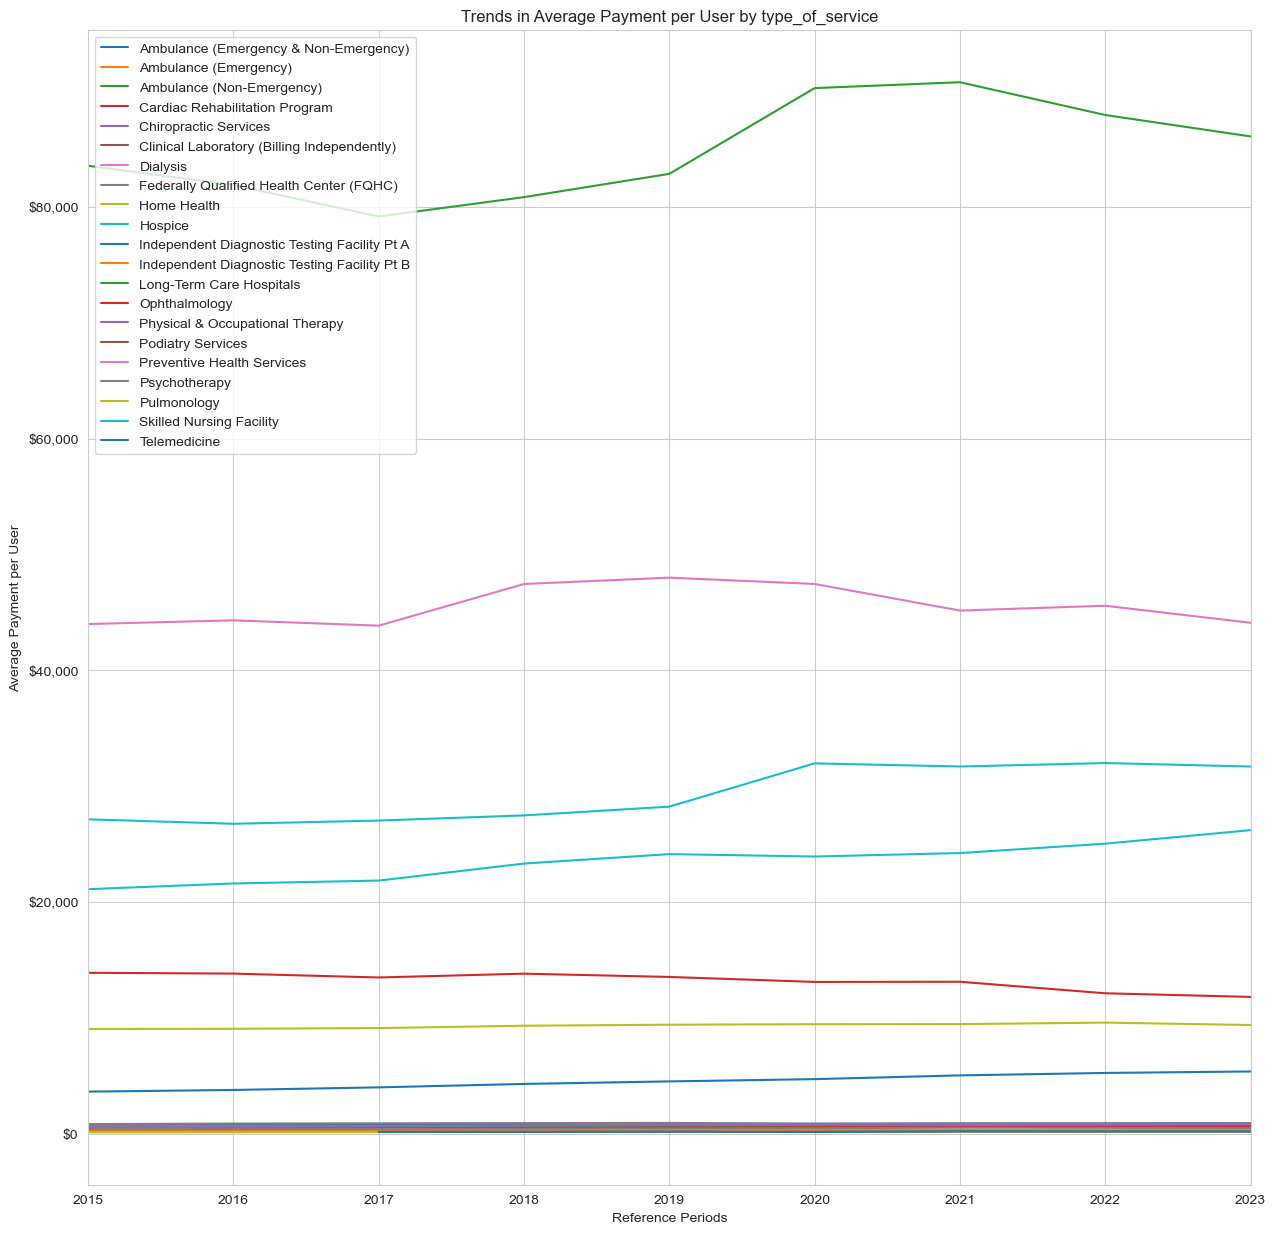

In [49]:
# groupby type_of_service and start_date
# calculate the mean of target for each group
trend1 = cbsa.groupby(['type_of_service', 'start_date']).agg({target_col: 'mean'})

# isolate unique services
type_of_service_trends = cbsa['type_of_service'].unique()

# size
plt.figure(figsize=(15, 15))

# line plot each type_of_service
for type_of_service in type_of_service_trends:
    type_of_service_data = trend1.loc[type_of_service]
    type_of_service_data['total_payment_adj_z'].plot(label=type_of_service)

# labels
plt.xlabel('Reference Periods')
plt.ylabel('Average Payment per User')
plt.title('Trends in Average Payment per User by type_of_service')

# legend
plt.legend(loc='upper left')

# format y-axis for readability
def format_dollars(y, pos):
    return '${:,.0f}'.format(y)
    
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_dollars))

plt.show()

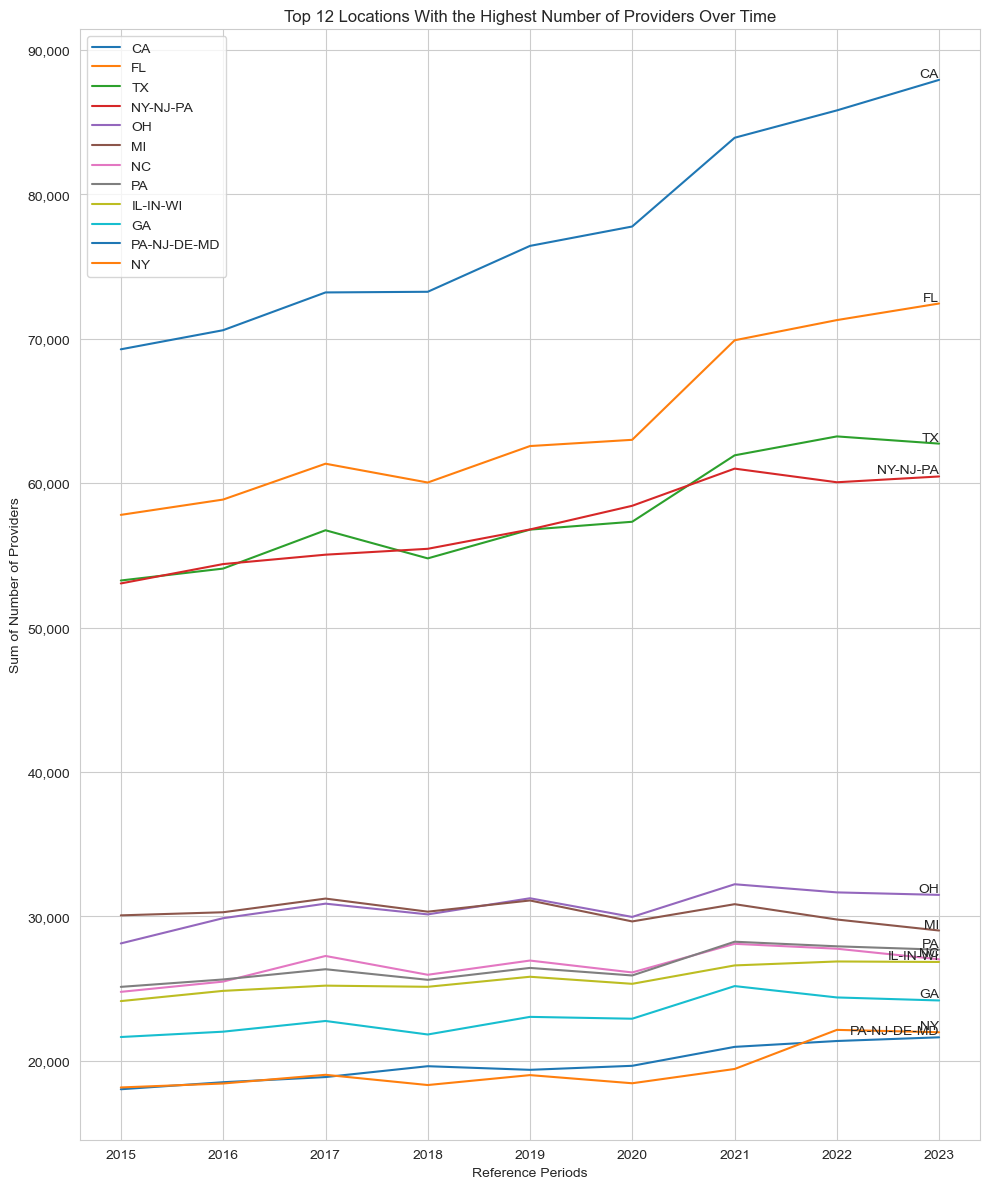

In [50]:
# groupby state and start date
# calculate the sum of 'number_of_providers' for each group
trend2 = cbsav1.groupby(['state', 'start_date'])['number_of_providers'].sum().reset_index()

# total number of providers for each state
total_providers_by_state = trend2.groupby('state')['number_of_providers'].sum()

# top 5 states with the highest total number of providers
top_12_states = total_providers_by_state.nlargest(12).index

# size
plt.figure(figsize=(10, 12))

# line plot the sum of 'number_of_providers' over time for each state
for state in top_12_states:
    state_data = trend2[trend2['state'] == state]
    plt.plot(state_data['start_date'], state_data['number_of_providers'], label=state)

    # annotate line
    last_data_point = state_data.iloc[-1]
    plt.text(last_data_point['start_date'], last_data_point['number_of_providers'], state, ha='right', va='bottom')

# labels
plt.xlabel('Reference Periods')
plt.ylabel('Sum of Number of Providers')
plt.title('Top 12 Locations With the Highest Number of Providers Over Time')

# legend
plt.legend(loc='upper left')

# format y-axis for readability
def format_dollars(y, pos):
    return '{:,.0f}'.format(y)
    
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_dollars))

# improve readability
plt.tight_layout()
plt.show()

#### **2. Visualize ratio of users to providers across CBSA**


Visualize `average_number_of_users_per_provider` across CBSA with folium.

$$ \text{Ratio} = \frac{ \text{number of providers} }{ \text{number of users} } $$

In [51]:
# merge datasets based on 'cbsatitle'
geo_merged = cbsa.merge(geo[['NAME', 'INTPTLAT', 'INTPTLONG']], left_on='cbsatitle', right_on='NAME', how='left')

# drop the duplicated 'NAME' column
geo_merged.drop('NAME', axis=1, inplace=True)

geo_merged.shape

(157133, 25)

In [52]:
null_geometry = geo_merged[geo_merged['INTPTLAT'].isnull() | geo_merged['INTPTLONG'].isnull()]
null_geometry.shape[0]

0

In [53]:
cbsatitles_with_zero_providers = cbsa[cbsa['number_of_providers'] == 0]['cbsa']

cbsatitles_with_zero_providers

7917      49500
8115      18380
9029      18380
9926      17640
9943      18380
          ...  
156474    19540
156551    23140
156632    26780
156796    34300
157126    49500
Name: cbsa, Length: 923, dtype: category
Categories (961, object): ['10100', '10140', '10180', '10220', ..., '49700', '49740', '49780', '49820']

In [54]:
# subset most recent data from 2023
geo_merged_2023 = geo_merged[geo_merged['year'] == 2023]

# subset zero providers
zero_providers = geo_merged_2023[geo_merged_2023['number_of_providers'] == 0][['cbsatitle','INTPTLAT', 'INTPTLONG', 'number_of_providers']]

# subset providers per geo mapped cbsatitle
providers_per_cbsatitle = geo_merged_2023.groupby('cbsatitle')[['INTPTLAT', 'INTPTLONG', 'number_of_providers']].first().reset_index()

# count beneficiaries per cbsa
beneficiaries_count = geo_merged_2023.groupby(['cbsatitle', 'INTPTLAT', 'INTPTLONG'])['number_of_fee_for_service_beneficiaries'].count().reset_index()

In [55]:
# subset most recent data from 2023
geo_merged_2023 = geo_merged[geo_merged['year'] == 2023]

# subset zero providers
zero_providers = geo_merged_2023[geo_merged_2023['number_of_providers'] == 0][['cbsatitle','INTPTLAT', 'INTPTLONG', 'number_of_providers']]

# subset providers per geo mapped cbsatitle
providers_per_cbsatitle = geo_merged_2023.groupby('cbsatitle')[['INTPTLAT', 'INTPTLONG', 'number_of_providers']].first().reset_index()

# count beneficiaries per cbsa
beneficiaries_count = geo_merged_2023.groupby(['cbsatitle', 'INTPTLAT', 'INTPTLONG'])['number_of_fee_for_service_beneficiaries'].count().reset_index()

In [56]:
# USA default
site_map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# MarkerCluster object for clustering markers
marker_cluster_with_providers = MarkerCluster().add_to(site_map)

# for every row in subset that meet condition, add to marker_cluster_with_providers object
for idx, row in providers_per_cbsatitle.iterrows():
    cbsatitle = row['cbsatitle']
    INTPTLAT = row['INTPTLAT']
    INTPTLONG = row['INTPTLONG']
    num_providers = row['number_of_providers']
    tooltip = f"{cbsatitle}: {num_providers} providers"
    if num_providers > 0:
        marker = folium.Marker(
            location=[INTPTLAT, INTPTLONG],
            popup=f"{cbsatitle}: {num_providers} providers",
            tooltip=tooltip,
        )
        marker.add_to(marker_cluster_with_providers)

# for every row in subset that meet condition, add CircleMarker
for idx, row in zero_providers.iterrows():
    cbsatitle = row['cbsatitle']
    INTPTLAT = row['INTPTLAT']
    INTPTLONG = row['INTPTLONG']
    num_providers = row['number_of_providers']
    tooltip = f"{cbsatitle}: {num_providers} providers"
    folium.CircleMarker(
        location=[INTPTLAT, INTPTLONG],
        radius=5,
        color='purple',
        fill=True,
        fill_color='purple',
        fill_opacity=0.4,
        tooltip=tooltip
        ).add_to(site_map)

# for every row in subset that meet condition, add CircleMarker
for idx, row in beneficiaries_count.iterrows():
    cbsatitle = row['cbsatitle']
    INTPTLAT = row['INTPTLAT']
    INTPTLONG = row['INTPTLONG']
    num_beneficiaries = row['number_of_fee_for_service_beneficiaries']
    folium.CircleMarker(
        location=[INTPTLAT, INTPTLONG],
        radius=1,
        color='teal',
        fill=True,
        fill_color='teal',
        fill_opacity=0.4,
        tooltip=tooltip
        ).add_to(site_map)
        
# Display the map
site_map

![MAP](map.PNG)


| Marker Color | Description                                                                                     |
|--------------|-------------------------------------------------------------------------------------------------|
| <font color="teal">**Teal**</font>        | Teal markers indicate aggregate of beneficiaries enrolled in a fee-for-service healthcare program within a CBSA.                |
| <font color="green">**Green**</font>        | Green markers indicate areas with a high number of providers or good conditions.                |
| <font color="orange">**Yellow**</font>       | Orange markers indicate areas with a moderate number of providers or intermediate conditions.   |
| <font color="blue">**Blue**</font>         | Blue markers represent unclustered default or baseline state. May indicate areas with a low number of providers or poor conditions.                                               |
| <font color="purple">**Purple**</font>       | Purple markers indicate locations with no providers.                                              |

## Determine Data Mining Task


    1. Baseline Model
    2. Split Data and Validate Partitions 
    3. Isolate predictor and response variables 
    4. Analyze and find correlation between predictors
    5. Build and validate machine learning models
    6. Select best performing model
    7. Feature importance
    8. Deployment Planning


**Modeling Average Total Payment per User**

    Continuous Probability Distribution: Gamma Distribution
    Target: Average Total Payment (continuous variable)
    Range: non-negative values
    parameters depend on factors including: 
        historical distribution of claims
        type of service
        location

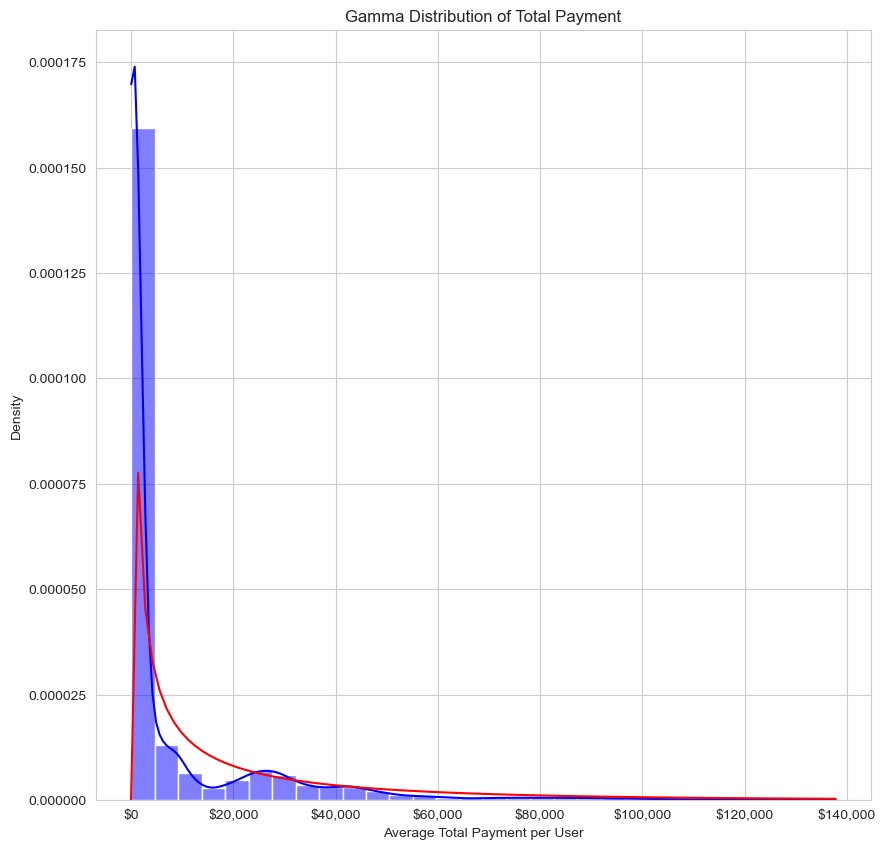

In [57]:
plt.figure(figsize=(10,10))

# extract average total payment per user data
payment_data = cbsa[target_col]

# fit a gamma distribution (to payment data
shape, loc, scale = stats.gamma.fit(payment_data)

# binned histogram with blue line kde
sns.histplot(payment_data, kde=True, color='blue', bins=30, stat='density')

# points for the gamma distribution
x = np.linspace(0, payment_data.max(), 100)
y = stats.gamma.pdf(x, shape, loc, scale)

# plot red line gamma distribution
plt.plot(x, y, 'r-', label='gamma pdf')

# labels
plt.xlabel('Average Total Payment per User')
plt.ylabel('Density')
plt.title('Gamma Distribution of Total Payment')

# format x-axis for readability
def format_dollars(x, pos):
    return '${:,.0f}'.format(x)
# apply format
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_dollars))

# plot
plt.show()

The range of possible values of the random variable is visualized by the gamma distribution curve.

    blue line = kernel density estimate (KDE by sns) plot overlaid on the histogram
    red line = the gamma pdf
    total area under the PDF curve = 1

#### **1. Split Data and validate partitions**

In [58]:
# use split command to partition the dataset 33% training
train_cbsa, test_cbsa = train_test_split(cbsa, test_size = .33, random_state =7)

In [59]:
train_cbsa.shape, test_cbsa.shape

((105279, 23), (51854, 23))

In [60]:
# confirm proportions
bool(train_cbsa.shape[0] == round(cbsa.shape[0]*.67))

True

In [61]:
# validate partition
targetz_train = train_cbsa[['total_payment_adj_z']] 
targetz_test = test_cbsa[['total_payment_adj_z']]

statistic, p_value = ttest_ind(targetz_train, targetz_test)

print("Test statistic:", statistic)
print("p-value:", p_value)

Test statistic: [-0.10802334]
p-value: [0.91397731]


The p value is greater than the significance level of 0.05, therefore, there is no statistically significant difference in the two datasets on the target column. This valudates that the training and test sets should be similar on `total_payment_adj_z`.

#### **2. Isolate target and predictors**

In [62]:
# predicting total_payment_adj_z
y_train = train_cbsa['total_payment_adj_z']
y_test = test_cbsa['total_payment_adj_z']

In [63]:
# isolate predictors
main_predictors = ['total_payment_adj_z','number_of_fee_for_service_beneficiaries',
    'number_of_providers','number_of_users','number_of_dual_eligible_users','cbsa',
    'type_of_service_encoded']

#### **3. Baseline Model for Predicting Adjusted Total Payment with the Average Value of the Dataset**

In [64]:
average_payment_adj_z = train_cbsa['total_payment_adj_z'].mean()
baseline_pred = [average_payment_adj_z]*len(test_cbsa)

# mean absolute error
mean_absolute_error(baseline_pred, y_test)

11129.539914803987

On average, the baseline model prediction is off by $11,480.73

#### **4. Analyze and find correlation between predictors**

PCA - The CBSA dataset with has predictors, contributing to its high dimensionality. Many of these predictors are derived from other columns of the dataset, leading to multicollinearity concerns due to a significant degree of correlation between two or more predictors. To address multicollinearity concerns, dimension reduction techniques are performed. Instead of using derived or calculated predictors, original raw data are used. Redundant variables that do not improve model performance are also removed. For example, variable CBSA values also represent specific city and state variables. The variable that gives more information are kept for analysis.

In [65]:
train_cbsa[main_predictors].corr()

,total_payment_adj_z,number_of_fee_for_service_beneficiaries,number_of_providers,number_of_users,number_of_dual_eligible_users,cbsa,type_of_service_encoded
total_payment_adj_z,1.000000,0.032669,-0.072300,-0.067963,-0.059088,-0.000911,0.032298
number_of_fee_for_service_beneficiaries,0.032669,1.000000,0.482064,0.634771,0.637030,0.012783,-0.009368
number_of_providers,-0.072300,0.482064,1.000000,0.677749,0.606236,0.000202,0.127118
number_of_users,-0.067963,0.634771,0.677749,1.000000,0.917567,0.007443,0.036279
number_of_dual_eligible_users,-0.059088,0.637030,0.606236,0.917567,1.000000,0.013649,0.014349
cbsa,-0.000911,0.012783,0.000202,0.007443,0.013649,1.000000,-0.000449
type_of_service_encoded,0.032298,-0.009368,0.127118,0.036279,0.014349,-0.000449,1.000000


<Axes: >

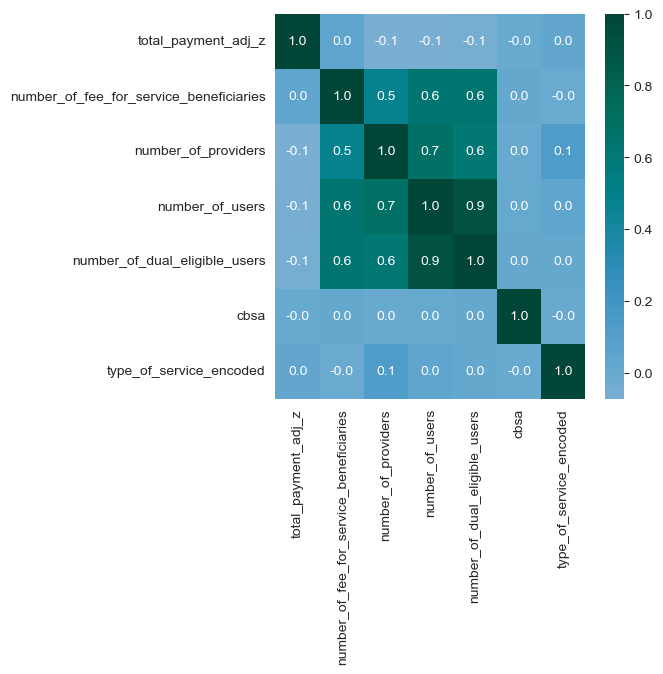

In [66]:
corr = train_cbsa[main_predictors].corr()
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
sns.heatmap(corr, annot=True, fmt=".1f", center =0, ax=ax, cmap='PuBuGn')

In [67]:
# ML model of predictors for training
predictors = ['number_of_fee_for_service_beneficiaries','number_of_providers','number_of_users','number_of_dual_eligible_users']

X_train_4 = train_cbsa[predictors]
X_train_4.shape

(105279, 4)

In [68]:
# ML model of predictors for testing

X_test_4 = test_cbsa[predictors]
X_test_4.shape

(51854, 4)

#### **5. Build and validate machine learning models**

**Determine which combination of transformation and ML models generate better prediction accuracy**

In [69]:
# fit the random forest regressor model to the training sets (predictors, and target y)
forest_base = RandomForestRegressor(n_estimators=50, max_depth=5).fit(X_train_4, y_train)

# make predictions on predictor test set with random forest model algo
forest_base_preds = forest_base.predict(X_test_4)

# MAE of random forest
mean_absolute_error(y_test, forest_base_preds)

7696.718388700278

In [70]:
# feature importances
feature_importances = forest_base.feature_importances_
print("Feature Importances:", feature_importances)

Feature Importances: [0.29961804 0.11301811 0.50364829 0.08371555]


In [71]:
# define pipeline with preprocessing transformers and estimator of model
scale_pca_forest_pipeline = Pipeline(steps=[('Scaler', StandardScaler()),
    ('PCA', PCA(n_components=2)),
    ('Forest', RandomForestRegressor(n_estimators=50, max_depth=5))])
scale_pca_forest_pipeline

Pipeline(steps=[('Scaler', StandardScaler()), ('PCA', PCA(n_components=2)),
                ('Forest',
                 RandomForestRegressor(max_depth=5, n_estimators=50))])

In [72]:
# fit the pipeline model to the training data
scale_pca_forest_pipeline.fit(X_train_4, y_train)

# make predictions on the test predictors with the pipeline model
scale_pca_forest_pipeline_test_preds = scale_pca_forest_pipeline.predict(X_test_4)

# compare prediction accuracy of test against pipeline model prediction
mean_absolute_error(y_test, scale_pca_forest_pipeline_test_preds)

8974.195737962431

In [73]:
# define pipeline with preprocessing transformers and estimator of model
scale_pca_forest_pipeline = Pipeline(steps=[('Scaler', Normalizer()),
    ('PCA', PCA(n_components=2)),
    ('Forest', RandomForestRegressor(n_estimators=50, max_depth=5))])
scale_pca_forest_pipeline

Pipeline(steps=[('Scaler', Normalizer()), ('PCA', PCA(n_components=2)),
                ('Forest',
                 RandomForestRegressor(max_depth=5, n_estimators=50))])

In [74]:
# fit the pipeline model to the training data
scale_pca_forest_pipeline.fit(X_train_4, y_train)

# make predictions on the test predictors with the pipeline model
scale_pca_forest_pipeline_test_preds = scale_pca_forest_pipeline.predict(X_test_4)

# compare prediction accuracy of test against pipeline model prediction
mean_absolute_error(y_test, scale_pca_forest_pipeline_test_preds)

7085.82300694736

Normalization is a better transformation to apply on predictors.

**Add encoded variables to predict price**

In [75]:
train_cbsa['type_of_service'].value_counts()

type_of_service
Preventive Health Services                      5617
Independent Diagnostic Testing Facility Pt A    5585
Ophthalmology                                   5532
Home Health                                     5506
Clinical Laboratory (Billing Independently)     5478
Pulmonology                                     5423
Podiatry Services                               5419
Physical & Occupational Therapy                 5405
Ambulance (Emergency)                           5392
Hospice                                         5392
Ambulance (Emergency & Non-Emergency)           5390
Chiropractic Services                           5359
Psychotherapy                                   5264
Independent Diagnostic Testing Facility Pt B    5258
Skilled Nursing Facility                        5219
Ambulance (Non-Emergency)                       4907
Federally Qualified Health Center (FQHC)        4770
Dialysis                                        4543
Cardiac Rehabilitation Program

In [76]:
train_encoded = pd.get_dummies(train_cbsa['type_of_service'])
train_encoded = train_encoded.astype(int)
train_encoded.head()

,Ambulance (Emergency & Non-Emergency),Ambulance (Emergency),Ambulance (Non-Emergency),Cardiac Rehabilitation Program,Chiropractic Services,Clinical Laboratory (Billing Independently),Dialysis,Federally Qualified Health Center (FQHC),Home Health,Hospice,...,Independent Diagnostic Testing Facility Pt B,Long-Term Care Hospitals,Ophthalmology,Physical & Occupational Therapy,Podiatry Services,Preventive Health Services,Psychotherapy,Pulmonology,Skilled Nursing Facility,Telemedicine
20769,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22015,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10871,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59643,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
103926,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [77]:
# concatenate dummy with train data
train_cbsa_service_encoded = pd.concat([X_train_4, train_encoded], axis=1)
X_train_25 = pd.concat([X_train_4, train_encoded], axis=1)

# concatenate target column
train_cbsa_service_encoded['target'] = y_train

In [78]:
test_encoded = pd.get_dummies(test_cbsa['type_of_service'])
test_encoded = test_encoded.astype(int)
test_encoded.head()

,Ambulance (Emergency & Non-Emergency),Ambulance (Emergency),Ambulance (Non-Emergency),Cardiac Rehabilitation Program,Chiropractic Services,Clinical Laboratory (Billing Independently),Dialysis,Federally Qualified Health Center (FQHC),Home Health,Hospice,...,Independent Diagnostic Testing Facility Pt B,Long-Term Care Hospitals,Ophthalmology,Physical & Occupational Therapy,Podiatry Services,Preventive Health Services,Psychotherapy,Pulmonology,Skilled Nursing Facility,Telemedicine
117099,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
141794,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
30778,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
133810,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2610,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
# concatenate dummy with test data
test_cbsa_service_encoded = pd.concat([X_test_4, test_encoded], axis=1)

# concatenate target column
test_cbsa_service_encoded['target'] = y_test

**OLS Regression**

In [80]:
X_train_25 = sm.add_constant(X_train_25)
# test_cbsa_service_encoded = sm.add_constant(test_cbsa_service_encoded)

model01 = sm.OLS(y_train, X_train_25).fit()
model01.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     total_payment_adj_z   R-squared:                       0.939
Model:                             OLS   Adj. R-squared:                  0.939
Method:                  Least Squares   F-statistic:                 6.719e+04
Date:                 Fri, 12 Apr 2024   Prob (F-statistic):               0.00
Time:                         21:25:14   Log-Likelihood:            -1.0276e+06
No. Observations:               105279   AIC:                         2.055e+06
Df Residuals:                   105254   BIC:                         2.056e+06
Df Model:                           24                                         
Covariance Type:             nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                         9744.7945     13.321    731.562      0.000    9718.686    9770.903
number_of_fee_for_service_beneficiaries          0.0033      0.000     21.097      0.000       0.003       0.004
number_of_providers                             -0.1388      0.074     -1.870      0.062      -0.284       0.007
number_of_users                                 -0.0059      0.001     -4.236      0.000      -0.009      -0.003
number_of_dual_eligible_users                   -0.0092      0.007     -1.344      0.179      -0.023       0.004
Ambulance (Emergency & Non-Emergency)        -8980.9398     56.028   -160.294      0.000   -9090.754   -8871.126
Ambulance (Emergency)                        -9144.7172     56.014   -163.257      0.000   -9254.504   -9034.930
Ambulance (Non-Emergency)                    -9226.8871     58.573   -157.528      0.000   -9341.689   -9112.085
Cardiac Rehabilitation Program                3275.3689     64.520     50.765      0.000    3148.911    3401.827
Chiropractic Services                        -9595.6620     56.165   -170.848      0.000   -9705.744   -9485.580
Clinical Laboratory (Billing Independently)  -9507.4319     56.134   -169.371      0.000   -9617.453   -9397.411
Dialysis                                      3.561e+04     60.796    585.742      0.000    3.55e+04    3.57e+04
Federally Qualified Health Center (FQHC)     -8951.5519     59.400   -150.699      0.000   -9067.975   -8835.129
Home Health                                   -521.0752     55.424     -9.402      0.000    -629.706    -412.445
Hospice                                        1.36e+04     56.016    242.800      0.000    1.35e+04    1.37e+04
Independent Diagnostic Testing Facility Pt A -5255.3675     55.892    -94.027      0.000   -5364.915   -5145.820
Independent Diagnostic Testing Facility Pt B -9534.8656     56.665   -168.268      0.000   -9645.928   -9423.803
Long-Term Care Hospitals                      7.483e+04     83.112    900.355      0.000    7.47e+04     7.5e+04
Ophthalmology                                -9246.1441     55.568   -166.392      0.000   -9355.057   -9137.231
Physical & Occupational Therapy              -9110.0093     55.984   -162.724      0.000   -9219.738   -9000.280
Podiatry Services                            -9652.2158     55.828   -172.892      0.000   -9761.638   -9542.794
Preventive Health Services                   -9536.3942     56.903   -167.591      0.000   -9647.923   -9424.865
Psychotherapy                                -9376.3500     56.654   -165.502      0.000   -9487.391   -9265.309
Pulmonology                                  -9631.5000     56.655   -170.003      0.000   -9742.543   -9520.457
Skilled Nursing Facil

**Random Forest Regressor**

In [81]:
# define pipeline with preprocessing transformers and estimator of model
scale_pca_forest_pipeline = Pipeline(steps=[('Scaler', Normalizer()),
    ('PCA', PCA(n_components=2)),
    ('Forest', RandomForestRegressor(n_estimators=50, max_depth=5))])
scale_pca_forest_pipeline

Pipeline(steps=[('Scaler', Normalizer()), ('PCA', PCA(n_components=2)),
                ('Forest',
                 RandomForestRegressor(max_depth=5, n_estimators=50))])

In [82]:
# fit the pipeline model to the training data
scale_pca_forest_pipeline.fit(train_cbsa_service_encoded, y_train)

# make predictions on the test predictors with the pipeline model
scale_pca_forest_pipeline_test_preds = scale_pca_forest_pipeline.predict(test_cbsa_service_encoded)

# compare prediction accuracy of test against pipeline model prediction
mean_absolute_error(y_test, scale_pca_forest_pipeline_test_preds)

4088.964891516688

**Linear Regression**

In [83]:
# define pipeline with preprocessing transformers and estimator of model
scale_pca_lr_pipeline = Pipeline(steps=[('Scaler', Normalizer()),
    ('PCA', PCA(n_components=2)),
    ('LR', LinearRegression())])
scale_pca_lr_pipeline

Pipeline(steps=[('Scaler', Normalizer()), ('PCA', PCA(n_components=2)),
                ('LR', LinearRegression())])

In [84]:
# fit the pipeline model to the training data
scale_pca_lr_pipeline.fit(train_cbsa_service_encoded, y_train)

# make predictions on the test predictors with the pipeline model
scale_pca_lr_pipeline_test_preds = scale_pca_lr_pipeline.predict(test_cbsa_service_encoded)

# compare prediction accuracy of test against pipeline model prediction
mean_absolute_error(y_test, scale_pca_lr_pipeline_test_preds)

5102.924002526136

**Make ML based on the 4 predictors and the encoded service types**

**Baseline Model for Predicting Number of Providers**

**Determine which combination of transformation and ML models generate better prediction accuracy**

## Choose Data Mining Methods

## Apply Methods and Select Final Model

## Evaluate Performance

## **References**

Larose, C., & Larose, D. (2019). Data science using Python and R. John Wiley & Sons, Inc. 

Tan, P. N., Steinbach, M., Karpatne, A., & Kumar, V. (2019). Introduction to data mining (2nd ed.). Pearson.

https://data.cms.gov/summary-statistics-on-use-and-payments/program-integrity-market-saturation-by-type-of-service/market-saturation-utilization-core-based-statistical-areas

https://www.census.gov/geographies/reference-files/time-series/geo/gazetteer-files.html

https://meric.mo.gov/data/cost-living-data-series
